<a href="https://colab.research.google.com/github/SaketMunda/transfer-learning-with-tensorflow/blob/master/exercises_scaling_up_transfer_learning_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercises for Scaling Up Module of Transfer Learning with TensorFlow

This notebook covers the exercises and extra-curriculum for scaling up the dataset of Food Vision with 101 classes.

- [ ] Take 3 of your own photos of food and use the trained model to make predictions on them, share your predictions with the other students in Discord and show off your Food Vision model 🍔👁.
- [ ] Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?
- [ ] Recreate the first model (the feature extraction model) with [`mixed_precision`](https://www.tensorflow.org/guide/mixed_precision) turned on.
    - Does it make the model train faster?
    - Does it effect the accuracy or performance of our model?
    - What's the advantages of using `mixed_precision` training?

## Exercise 1

Take 3 of your own photos of food and use the trained model to make predictions on them, share your predictions with the other students in Discord and show off your Food Vision model 🍔👁.


In [1]:
# import the libaries
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# load the trained model
model = tf.keras.models.load_model('drive/MyDrive/Data Science/101_food_class_10_percent_saved_big_dog_model')

First upload images into your colab session, I uploaded images of chicken_biryani, chicken curry and paneer tikka.

### Load and Preprocess Images

In [5]:
# Load the classes in which the model was trained on

# Download the helper function
!wget https://raw.githubusercontent.com/SaketMunda/ml-helpers/master/helper_functions.py

# Import functions from helper_functions.py
from helper_functions import unzip_data, walk_through_dir, create_tensorboard_callback, plot_loss_curves

# Download Zipfile of Food101 Dataset
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

# Unzip the file
unzip_data('101_food_classes_10_percent.zip')


# Setup data inputs
import tensorflow as tf
IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

test_dir = '101_food_classes_10_percent/test/'

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SHAPE,
                                                                batch_size=BATCH_SIZE,
                                                                shuffle=False)# don't shuffle test data for prediction analysis


--2023-01-09 04:55:18--  https://raw.githubusercontent.com/SaketMunda/ml-helpers/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2904 (2.8K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   2.84K  --.-KB/s    in 0s      

2023-01-09 04:55:19 (43.9 MB/s) - ‘helper_functions.py’ saved [2904/2904]

--2023-01-09 04:55:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [ap

In [2]:
def load_prep_images(filename,img_size=224,scale=True):
  """
  Load the images from the filename and then decode them into tensors
  rescale it if needed
  """
  # read image file
  img = tf.io.read_file(filename)

  # decode the image file
  img = tf.io.decode_image(img)

  # resize the image
  img = tf.image.resize(img, [img_size,img_size])

  if scale:
    return img/255.
  else:
    return img

In [17]:
# Function for predict and plot the predictions
def plot_prediction(filename, model=model):
  """
  Function to do the prediction and then plot the prediction
  with images
  """

  img = load_prep_images(filename, scale=False) # for efficientnet models we not need tot rescale it

  pred_probs = model.predict(tf.expand_dims(img, axis=0), verbose=0)
  pred_class = test_data.class_names[pred_probs.argmax()]

  plt.figure(figsize=(10, 10))
  plt.title(f'Prediction:{pred_class}, prob:{pred_probs.max():.2f}')
  plt.imshow(img/255.)
  plt.axis(False);

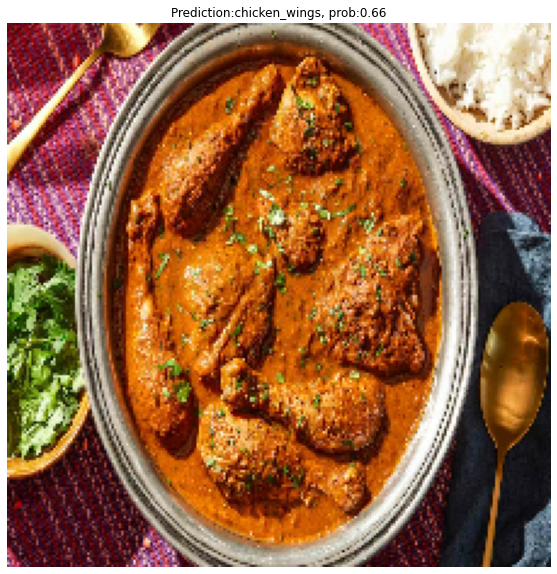

In [18]:
# prediction for chicken_curry image
plot_prediction('chicken_curry.jpeg', model)

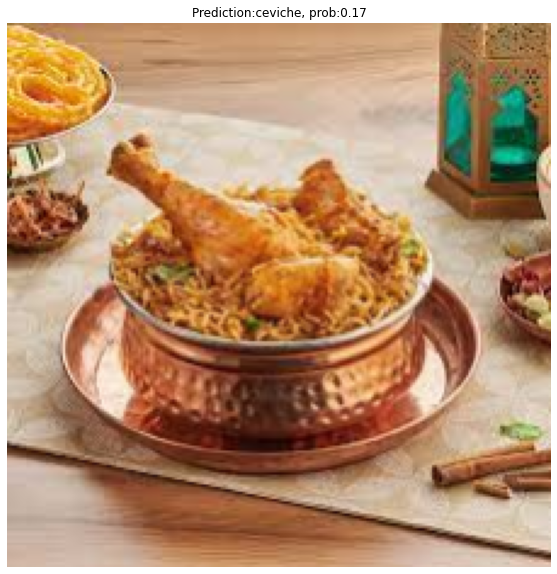

In [19]:
plot_prediction('chicken_biryani.jpeg', model)

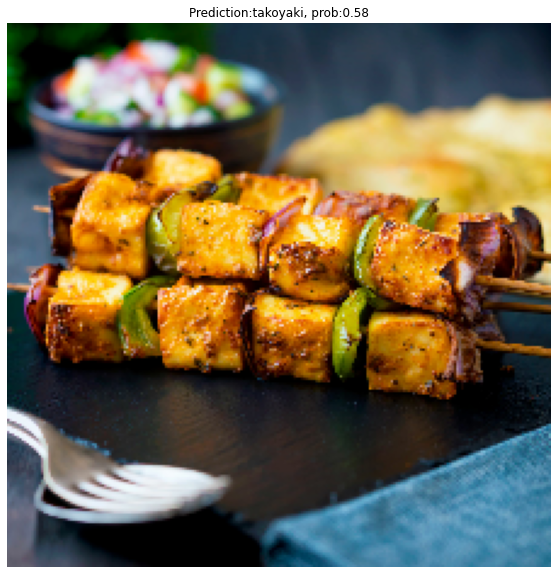

In [21]:
plot_prediction('paneer_tikka.jpeg', model)

## Exercise 2

Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?

For this we will consider the same data, but this time we can use the pretrained transfer learning model,

ResNetV250 architecture model

### Load and Preprocess Images

In [22]:
import tensorflow as tf
IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=IMG_SHAPE,
                                                                 batch_size=BATCH_SIZE,
                                                                 label_mode='categorical')

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SHAPE,
                                                                batch_size=BATCH_SIZE,
                                                                shuffle=False,
                                                                label_mode='categorical')

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


### Data Augmentation Layer

In [28]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_aug = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.Rescaling(1/255.)
])

### Create Callbacks

We need to create Tensorboard callbacks and ModelCheckpoint callbacks to monitor the performance and to create checkpoint of trained models respectively.

We have a helper function `create_tensorboard_callback` which will be useful for creating tensorboard callback, just need to pass the directory and experiment name.

In [29]:
# create modelcheckpoint callback

checkpoint_path = '10_percent_model_checkpoint/checkpoint.cpkt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_best_only=False,
                                                         save_weights_only=True,
                                                         save_freq='epoch',
                                                         verbose=1)

### Design Functional API

In [31]:
# Setup input_shape, base_model, freezing the top layers of base_model
input_shape = IMG_SHAPE + (3,)
base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name='input_layer')

# Add in data augmentation layer
x = data_aug(inputs)

# Give base_model inputs (after augmentation) and don't train it, means it will be in inference mode
x = base_model(x, training=False)

# Pool the most important features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(len(test_data.class_names), activation='softmax', name='output_layer')(x)

# Make a model with inputs and outputs
model = keras.Model(inputs, outputs)

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

### Train for 10 epochs

First we will train the feature extraction model for 10 epochs

In [32]:
epochs_train = 10

# fit the feature extracted model
feature_extraction_history = model.fit(train_data,
                                       epochs=epochs_train,
                                       validation_data=test_data,
                                       validation_steps=int(0.15 * len(test_data)),
                                       callbacks=[create_tensorboard_callback(dir_name='exercise_transfer_learning',
                                                                              experiment_name='feature_extraction_resnetv250_10_epochs'),])

Saving Tensorboard log files to: exercise_transfer_learning/feature_extraction_resnetv250_10_epochs/20230109-054303
Epoch 1/10
237/237 [==============================] - 161s 655ms/step - loss: 3.6627 - accuracy: 0.1864 - val_loss: 2.9935 - val_accuracy: 0.2895
Epoch 2/10
237/237 [==============================] - 103s 430ms/step - loss: 2.5990 - accuracy: 0.3757 - val_loss: 2.8849 - val_accuracy: 0.3332
Epoch 3/10
237/237 [==============================] - 75s 314ms/step - loss: 2.3087 - accuracy: 0.4323 - val_loss: 2.8822 - val_accuracy: 0.3324
Epoch 4/10
237/237 [==============================] - 80s 331ms/step - loss: 2.0999 - accuracy: 0.4731 - val_loss: 2.7553 - val_accuracy: 0.3644
Epoch 5/10
237/237 [==============================] - 63s 262ms/step - loss: 1.9638 - accuracy: 0.5030 - val_loss: 2.7863 - val_accuracy: 0.3663
Epoch 6/10
237/237 [==============================] - 69s 291ms/step - loss: 1.8322 - accuracy: 0.5228 - val_loss: 2.7920 - val_accuracy: 0.3618
Epoch 7/10
2